#1) VAE + K-Means Implementation (PyTorch)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


In [ ]:

# ------------------ VAE Model ------------------
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, 2)
        self.fc_logvar = nn.Linear(400, 2)

        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparam(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(logvar * 0.5)

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar, z

model = VAE()
opt = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# ------------------ Training ------------------
def loss_fn(x, recon, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

for epoch in range(5):
    total = 0
    for img, _ in loader:
        img = img.view(-1, 28*28)
        recon, mu, logvar, z = model(img)
        loss = loss_fn(img, recon, mu, logvar)

        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()
    print("Epoch:", epoch, "Loss:", total)

Epoch: 0 Loss: 11425695.963867188
Epoch: 1 Loss: 9993755.68359375
Epoch: 2 Loss: 9732983.829101562
Epoch: 3 Loss: 9589399.749023438
Epoch: 4 Loss: 9484221.99609375


In [ ]:
latents = []
labels_true = []

with torch.no_grad():
    for img, label in loader:
        img = img.view(-1, 28*28)
        _, _, _, z = model(img)
        latents.append(z)
        labels_true.extend(label.numpy())

latents = torch.cat(latents).numpy()

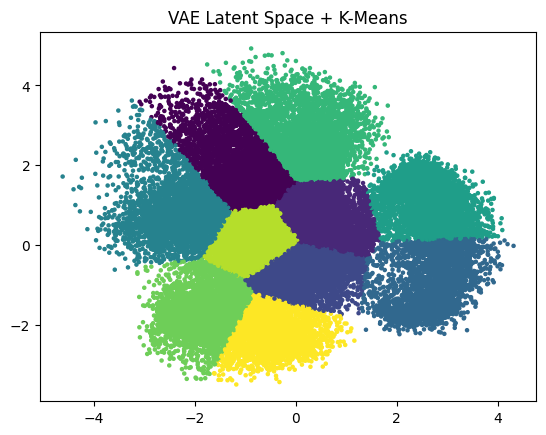

In [ ]:
# ------------------ K-Means Clustering ------------------
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(latents)

# ------------------ Visualization ------------------
plt.scatter(latents[:, 0], latents[:, 1], c=clusters, s=5)
plt.title("VAE Latent Space + K-Means")
plt.show()

#✅ 2) GRU Implementation (PyTorch)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ----------- Synthetic Data -----------
x = np.linspace(0, 200, 400)
data = np.sin(0.1 * x)

seq_len = 20
X, Y = [], []
for i in range(len(data)-seq_len):
    X.append(data[i:i+seq_len])
    Y.append(data[i+seq_len])

X = torch.tensor(X).float().unsqueeze(-1)
Y = torch.tensor(Y).float()

/tmp/ipython-input-3983091747.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X = torch.tensor(X).float().unsqueeze(-1)


In [ ]:
# ----------- GRU Model -----------
class GRUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, 32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1])
        return out

model = GRUNet()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [ ]:
# ----------- Train -----------
for epoch in range(50):
    pred = model(X).squeeze()
    loss = loss_fn(pred, Y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 10 == 0:
        print(epoch, loss.item())

0 0.47147393226623535
10 0.3751762807369232
20 0.28744909167289734
30 0.19731485843658447
40 0.09684213995933533


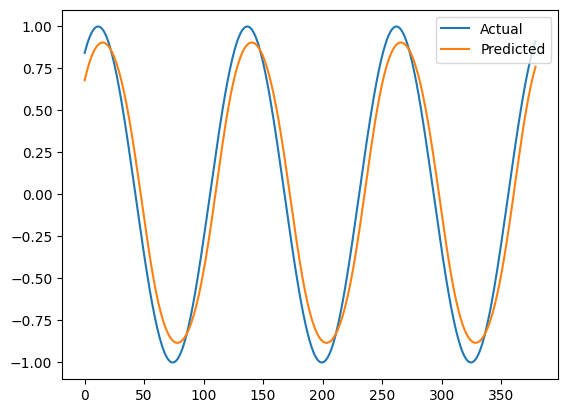

In [ ]:
# ----------- Predict -----------
pred = model(X).detach().numpy()

plt.plot(data[seq_len:], label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.show()

#✅ 3) DBSCAN Implementation (sklearn)

In [ ]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# ----------- Data -----------
X, Y = make_moons(n_samples=500, noise=0.08)

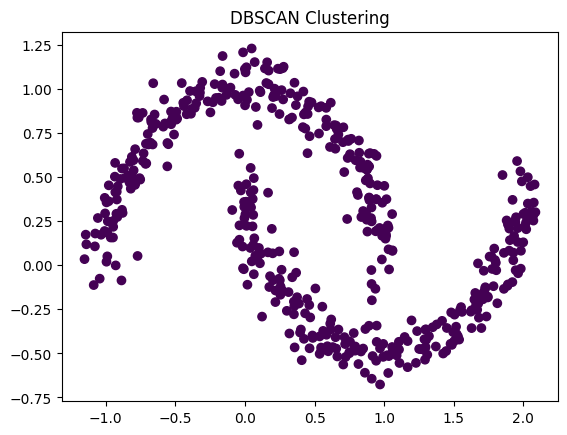

In [ ]:
# ----------- DBSCAN -----------
db = DBSCAN(eps=0.2, min_samples=5)
labels = db.fit_predict(X)

# ----------- Plot -----------
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis")
plt.title("DBSCAN Clustering")
plt.show()